# Fitting the dot model on Linux dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
import math
import os
import matplotlib.pyplot as plt
import numpy as np

from interank import linuxutils
from interank.models import DotModel
from interank.linuxdata import LinuxData
from datetime import datetime as dt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score

summaries_dir = '../trained-models/log-dir/'

## Load dataset

In [2]:
%%time
dataset = LinuxData("/data/datasets/linux")

train = dataset.get_train_data()
test = dataset.get_test_data()

print("Training set: {} edits".format(len(train[0])))
print("Test set: {} edits".format(len(test[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_subsystems))
print("––––––––––")

Training set: 495536 edits
Test set: 123883 edits
Number of users: 9672
Number of articles: 394
––––––––––
CPU times: user 1.34 s, sys: 48 ms, total: 1.39 s
Wall time: 1.36 s


## Tensorflow configuration

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Reset graph to run the notebook twice in a row without error 
tf.reset_default_graph()

# Number of latent factors for the MF term

# Basic model
model = DotModel(n_users=dataset.n_users,
                 n_articles=dataset.n_subsystems, 
                 n_dims=20, 
                 global_bias=True)

# Setup the optimisation procedure
minibatch_size = 2000
minibatch_size_tf = tf.Variable(minibatch_size, trainable=False)
num_batches = math.ceil(len(train[0]) / minibatch_size)
epochs = 50

# Define the cost
reg_coeff1 = 8
reg_coeff2 = 100
cost = (-model.log_likelihood
        + (reg_coeff1/num_batches) * (model.l2_difficulty + model.l2_skill)
        + (reg_coeff2/num_batches) * (model.l2_vec_user + model.l2_vec_article))

# Setup optimiser
learning_rate = 0.1

# Decaying learning rate
# decay_rate = 0.9
# global_step = 0
# Decaying learning rate
# batch_idx = tf.Variable(0, trainable=False)
# learning_rate_tf = tf.train.exponential_decay(
#     learning_rate=learning_rate,
#     global_step=(batch_idx * minibatch_size),
#     decay_steps=len(train[0]),
#     decay_rate=decay_rate,
#     staircase=True
# )
# train_step = tf.train.GradientDescentOptimizer(learning_rate_tf).minimize(cost, global_step=batch_idx)
# Adagrad
learning_rate_tf = tf.Variable(learning_rate, dtype=tf.float32)
train_step = tf.train.AdagradOptimizer(learning_rate_tf).minimize(cost)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
tf.summary.scalar("learning_rate", learning_rate_tf)
merged = tf.summary.merge_all()
    
log = 'tuned/optimization_{}_epochs_{}_minibatchsize_{}__learningrate_{}_date_{}'.format(
    'Adagrad',
    epochs,
    minibatch_size,
    learning_rate,
    dt.now().strftime('%Y-%m-%d-%H-%M-%S')
)
train_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/train')
test_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/test')

## Train the model

In [5]:
%%time
feed_test = {
    model.user_id: test[0],
    model.article_id: test[1],
    model.quality: test[2],
}

# Keep track of likelihood
test_likelihood = [-np.inf]

print('Total number of batches: {}'.format(num_batches))

def evaluate(session, step):
    avg_log_loss, probs, bias = session.run(
            [model.avg_log_loss, model.probability, model.global_bias], feed_dict=feed_test)
    
    labels = feed_test[model.quality].astype(int)
    auc = average_precision_score(labels, probs)
    
    summary = session.run(merged, feed_dict={**feed_test, auc_ph: auc})
    
    test_writer.add_summary(summary, global_step=step)
    test_writer.flush()
    
    return avg_log_loss, auc, bias
    
# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

with session.as_default():
    step = 0

    avg_log_loss, auc, bias = evaluate(session, step)
    print('Epoch 0 - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
          .format(avg_log_loss, auc, bias))
    
    for i in range(epochs):
        # Train the model on minibatch
        for j, minibatch in enumerate(LinuxData.minibatches(train, minibatch_size)):
            step += 1
            feed_dict = {
                model.user_id: minibatch[0],
                model.article_id: minibatch[1],
                model.quality: minibatch[2],
            }
            _ = session.run([train_step], feed_dict=feed_dict)

        avg_log_loss, auc, bias = evaluate(session, step)
        print('Epoch {} - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
              .format(i + 1, avg_log_loss, auc, bias))

Total number of batches: 248
Epoch 0 - avg. log-loss = 0.693147, AUC = 0.320, bias = 0.0
Epoch 1 - avg. log-loss = 0.588546, AUC = 0.526, bias = -0.3828637897968292
Epoch 2 - avg. log-loss = 0.588581, AUC = 0.528, bias = -0.38785168528556824
Epoch 3 - avg. log-loss = 0.589221, AUC = 0.525, bias = -0.3868368864059448
Epoch 4 - avg. log-loss = 0.588383, AUC = 0.528, bias = -0.40476852655410767
Epoch 5 - avg. log-loss = 0.588590, AUC = 0.528, bias = -0.3993528187274933
Epoch 6 - avg. log-loss = 0.588056, AUC = 0.528, bias = -0.41171717643737793
Epoch 7 - avg. log-loss = 0.588163, AUC = 0.527, bias = -0.4202040433883667
Epoch 8 - avg. log-loss = 0.588918, AUC = 0.525, bias = -0.41413697600364685
Epoch 9 - avg. log-loss = 0.588963, AUC = 0.526, bias = -0.4178537130355835
Epoch 10 - avg. log-loss = 0.588930, AUC = 0.526, bias = -0.42083674669265747
Epoch 11 - avg. log-loss = 0.588360, AUC = 0.527, bias = -0.43011510372161865
Epoch 12 - avg. log-loss = 0.588351, AUC = 0.528, bias = -0.4276320

## Evaluate

In [6]:
with session.as_default():
    probs = session.run(
            [model.probability], feed_dict=feed_test)

### Precision-recall curve

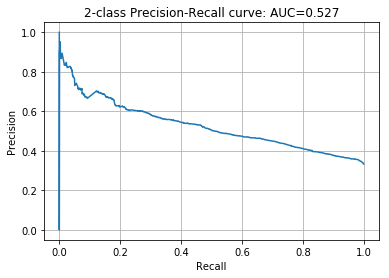

In [7]:
target = np.array([np.float32(t) for t in test[2]]).squeeze()
predictions = np.array(probs).squeeze()

average_precision = average_precision_score(target, predictions)
precision, recall, _ = precision_recall_curve(target, predictions)

plt.plot(recall, precision)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AUC={0:0.3f}'.format(
          average_precision))
plt.show()

## Qualitative results

In [8]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
subsystems = dataset.get_subsystems()
users = dataset.get_users()

In [9]:
linuxutils.print_subsystems_summary(difficulties, subsystems, n=10)

### 10 most difficult subsystems:
 1 +2.664 usr (796 patches, 70 users)
    rate: 1.8844%, main contributor: fujita.tomonori@lab.ntt.co.jp
 2 +1.327 include (398 patches, 101 users)
    rate: 7.7889%, main contributor: plagnioj@jcrosoft.com
 3 +1.038 lib (5642 patches, 707 users)
    rate: 15.9872%, main contributor: torvalds@linux-foundation.org
 4 +1.013 drivers/clk (495 patches, 81 users)
    rate: 34.3434%, main contributor: viresh.kumar@st.com
 5 +0.865 include/trace (547 patches, 81 users)
    rate: 17.7331%, main contributor: rostedt@goodmis.org
 6 +0.839 tools (9985 patches, 400 users)
    rate: 19.9800%, main contributor: acme@ghostprotocols.net
 7 +0.801 drivers/iio (305 patches, 38 users)
    rate: 43.2787%, main contributor: lars@metafoo.de
 8 +0.780 fs/ceph (314 patches, 28 users)
    rate: 25.1592%, main contributor: sage@newdream.net
 9 +0.779 fs (9421 patches, 713 users)
    rate: 18.1934%, main contributor: torvalds@linux-foundation.org
10 +0.752 drivers/md (4800 patch

In [10]:
def estimate_churn(idx):
    '''Estimates the number of commits in subsystem.'''
    c = list()
    for _, sid in enumerate(idx[:cutoff]):
        diff = difficulties[sid]
        sub = subsystems[sid]
        rate = sub[3]
        num_patch = sub[1]
        churn = rate * num_patch
        c.append(churn)
    return c


idx = np.argsort(difficulties)
cutoff = int(np.ceil(0.25 * len(idx)))

neg = estimate_churn(idx[:cutoff])
pos = estimate_churn(idx[::-1][:cutoff])

avg_pos = np.mean(pos)
avg_neg = np.mean(neg)

print('More difficult: avg. churn = {:.2f}'.format(avg_pos))
print('Less difficult. avg. churn = {:.2f}'.format(avg_neg))

More difficult: avg. churn = 833.56
Less difficult. avg. churn = 687.19


In [11]:
linuxutils.print_users_summary(skills, users, n=10)

### 10 most skilled users:
 1 +1.914 andrew.vasquez@qlogic.com from qlogic (538 patches, 4 subsystems)
    rate: 84.5725%, main sub: drivers/scsi
 2 +1.909 knan-lkml@anduin.net from anduin (78 patches, 3 subsystems)
    rate: 96.1538%, main sub: drivers/ata
 3 +1.837 james.smart@emulex.com from emulex (253 patches, 2 subsystems)
    rate: 93.2806%, main sub: drivers/scsi
 4 +1.766 tixy@yxit.co.uk from yxit.co (146 patches, 1 subsystems)
    rate: 87.6712%, main sub: arch/arm
 5 +1.738 agk@redhat.com from redhat (216 patches, 3 subsystems)
    rate: 69.4444%, main sub: drivers/md
 6 +1.705 philipp.reisner@linbit.com from linbit (530 patches, 9 subsystems)
    rate: 75.8491%, main sub: block
 7 +1.572 madhu.iyengar@qlogic.com from qlogic (111 patches, 2 subsystems)
    rate: 86.4865%, main sub: drivers/scsi
 8 +1.548 fenkes@de.ibm.com from de.ibm (104 patches, 4 subsystems)
    rate: 87.5000%, main sub: drivers/infiniband
 9 +1.544 christof.schmit@de.ibm.com from de.ibm (90 patches, 3 su

### Histograms of skills and difficulties

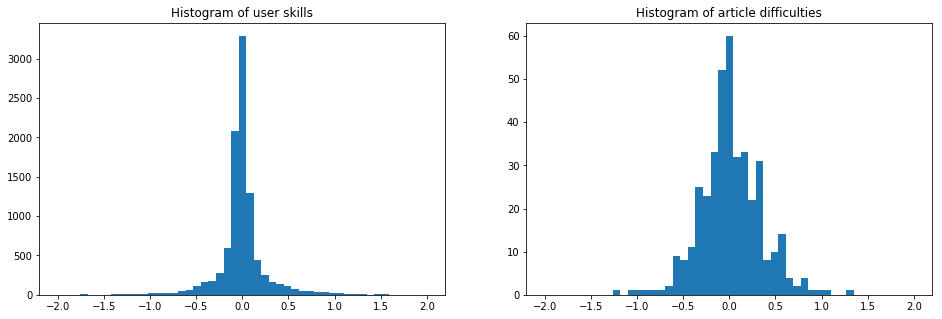

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

### Histograms of labels and predictions

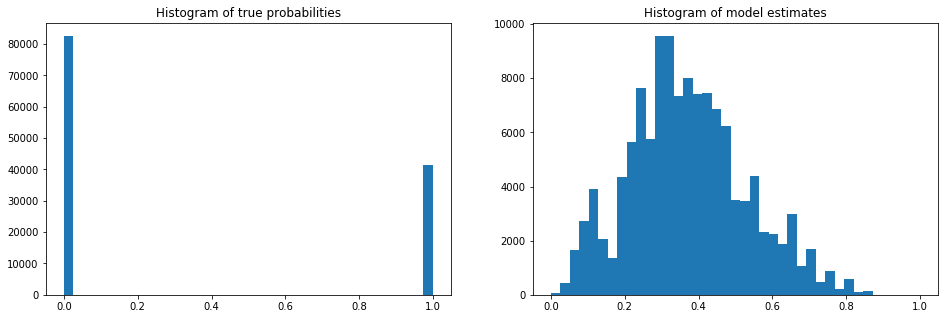

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

In [14]:
saver = tf.train.Saver()
saver.save(session, "../trained-models/linux/dot.ckpt")

with open('../data/linux-dot-probs.txt', 'w') as f:
    f.writelines(['{:.20f}\n'.format(p) for p in probs[0]])